### Import and read data

In [11]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Here we read the data: there are three dataframes: the AmBe data with NR band selection (`nr`), a combination of all ER data, with ER band selection (`er`), and the NR selection applied on BG data (`bg_nr`). Note that the BG livetime is half of the AmBe livetime, so for the contamination, you should multiply the population by two.

In [4]:
nr, er, bg_nr = pickle.load(open('highfield_dataframes.pickle', 'rb'))

All dataframes contain the event-by-event information required...

In [6]:
nr.head()

,run_number,event_number,s1_area_midpoint,s1_center_time,s1_left,s1_n_saturated_channels,s1_range_20p_area,s1_range_80p_area,s1_right,s1_time_from_midpoint_10p,...,s1_10_percentile_point,s1_20_percentile_point,s1_30_percentile_point,s1_40_percentile_point,s1_fraction_outside_pulse,s1_10_percentile_point_pax,s1_shift_error,s1_20_percentile_point_pax,s1_30_percentile_point_pax,s1_40_percentile_point_pax
540,0,540,34504.082031,34514.984375,17233.0,0.0,9.372392,72.916788,17294.0,-14.869240,...,75.213614,77.901925,81.747431,85.725104,9.625401e-09,75.212791,0.984375,77.901103,81.746609,85.724283
693,0,693,81638.390625,81647.546875,40802.0,0.0,6.905169,59.901494,40875.0,-9.056193,...,81.337993,83.576320,85.547583,87.603758,-6.711568e-09,81.334432,-0.453125,83.572760,85.544023,87.600198
798,0,798,58629.832031,58626.707031,29296.0,0.0,4.003010,25.680164,29329.0,-15.204214,...,88.627424,90.917856,97.654896,101.804348,5.186011e-09,88.627818,0.707031,90.918250,97.655288,101.804741
1071,0,1071,81643.140625,81645.750000,40804.0,0.0,5.839726,31.362469,40856.0,-10.946837,...,86.192020,88.649095,91.221984,93.941129,-6.944415e-09,86.193788,-0.250000,88.650862,91.223752,93.942897
1162,0,1162,81653.210938,81659.093750,40801.0,0.0,15.553748,67.444182,40890.0,-22.232770,...,70.975885,75.817257,80.992886,86.167310,5.250868e-08,70.978167,-0.906250,75.819539,80.995167,86.169590


...Such as the S1 pulse!

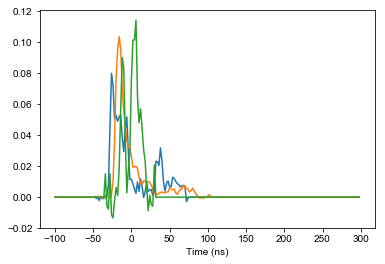

In [14]:
n_to_plot = 3

n_plotted = 0
for i, ev in nr.iterrows():
    plt.plot(np.linspace(-100, 300, 201)[:-1], np.array(ev['s1_pulse']) / ev['s1'])
    n_plotted += 1
    if n_plotted >= n_to_plot:
        break
plt.xlabel('Time (ns)')

### Alignment functions

In [17]:
def build_pulse_hist_entries(d, alignment_field):
    '''
    Align the S1 pulses. This assumes 400 ns of data and a field (`alignment_field`) that is given in units of 
    time since start of waveform in ns. This is put at the zero point, which is 100 ns in the waveform.
    The function returns two arrays, one containing the time points (shifted by the alignment field) and 
    one containing the weight, so that lower-than 1 bin sampling and alignment is possible.
    '''
    time_edges = np.linspace(-100, 300, 201)
    # Arbitrarily put the first sample EXACTLY at zero rather than at bin edges
    time = time_edges[:-1]
    time_entries = []
    weight_entries = []
    
    for i, ev in d.iterrows():
        time_entries.append(time + 100 - ev[alignment_field])
        weight_entries.append(np.array(ev['s1_pulse']) / ev['s1'])
    
    return np.concatenate(time_entries), np.concatenate(weight_entries)

def compute_average_pulse(d, alignment_field, dt = 2):
    '''
    Compute the average pulse, calling the underlying `build_pulse_hist_entries` routine. 
    This assumes 400 ns of data and a field (`alignment_field`) that is given in units of 
    time since start of waveform in ns. This is put at the zero point, which is 100 ns in the waveform.
    dt is sample time in ns, which may be lower than the raw sample of 2 ns. Go ahead and try!
    '''
    n_bins_time = np.floor(400 / dt) + 1
    if 400 % dt:
        print('Warning: please use a divisor of 400 for your time bins (i.e. 1, 0.2, 200, ...) .')
    time_edges = np.linspace(-100, 300, n_bins_time)
    times, weights = build_pulse_hist_entries(d, alignment_field)
    
    # This takes only the left bin edges, so that the first sample is zero.
    time = time_edges[:-1]
    amplitude, _ = np.histogram(times, bins=time_edges, weights=weights)
    # Normalization
    amplitude = amplitude / len(d) / dt
    
    return time, amplitude

def plot_average_pulse_in_slice(d, alignment_field, dt = 2, cs1_range=(0, np.inf), **kwargs):
    sel = (d['cs1'] >= cs1_range[0]) & (d['cs1'] < cs1_range[1])
    time, average_pulse = compute_average_pulse(d[sel], alignment_field, dt)
    plt.plot(time, average_pulse, **kwargs)
    plt.xlabel('Time (ns)')
    plt.ylabel('Average pulse ((%d ns)$^{-1}$)' % dt)
    return 

### Check out the pulses

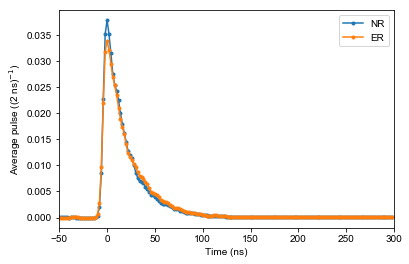

In [18]:
plot_average_pulse_in_slice(nr, 's1_10_percentile_point_pax', dt=2, cs1_range=(30, 40), label='NR', marker='.')
plot_average_pulse_in_slice(er, 's1_10_percentile_point_pax', dt=2, cs1_range=(30, 40), label='ER', marker='.')
plt.xlim(-50, 300)
plt.legend()
# plt.yscale('log')
plt.show()